#Packages

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!cp -R /content/drive/MyDrive/COSRMAL_CHALLENGE/train /content/train

^C


In [27]:
!cp -R /content/drive/MyDrive/COSRMAL_CHALLENGE/pyAudioAnalysis /content/pyAudioAnalysis

^C


In [ ]:
!pip install shap
!pip install eyed3
!pip install pydub

In [ ]:
!wget https://corsmal.eecs.qmul.ac.uk/data/CCM/ccm_train_annotation.json

In [95]:
import json
import pandas as pd
import os
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython
import scipy
import wave
import seaborn as sns
import IPython.display as ipd
import librosa
import torch
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Module
from pyAudioAnalysis import audioTrainTest as aT
from pyAudioAnalysis import MidTermFeatures as aF

# EDA

In [96]:
f = open('./ccm_train_annotation.json')
data = json.load(f)

gt = pd.DataFrame(data['annotations'])
assert len(gt) == len(os.listdir('./train/audio')), "Same number of data"

gt['nframes'] = gt['id'].apply(lambda f: wave.open('./train/audio/' + '{:06d}'.format(f)+'.wav').getnframes())
gt.head()


,id,container id,scenario,background,illumination,width at the top,width at the bottom,height,depth,container capacity,container mass,filling type,filling level,filling density,filling mass,object mass,handover starting frame,handover start timestamp,handover hand,nframes
0,0,2,2,1,0,69.0,42.0,72.0,-1.0,185.000,2.0,2,1,0.82,76.0,78.0,-1,-1,-1,291576
1,1,7,0,0,0,193.0,193.0,241.0,69.0,3209.397,59.0,0,0,0.00,0.0,59.0,-1,-1,-1,118483
2,2,2,0,1,0,69.0,42.0,72.0,-1.0,185.000,2.0,3,1,1.00,93.0,95.0,-1,-1,-1,572008
3,3,8,0,1,0,135.0,135.0,164.0,56.0,1239.840,31.0,0,0,0.00,0.0,31.0,-1,-1,-1,141680
4,4,4,1,1,0,88.0,56.0,91.0,-1.0,296.000,86.0,1,1,0.34,45.0,131.0,-1,-1,-1,138681


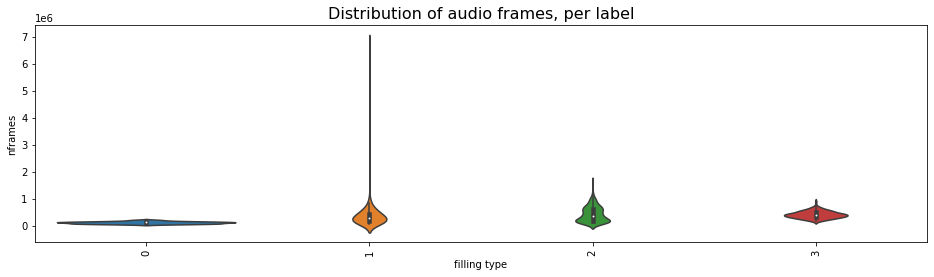

In [97]:
_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="filling type", y="nframes", data=gt)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

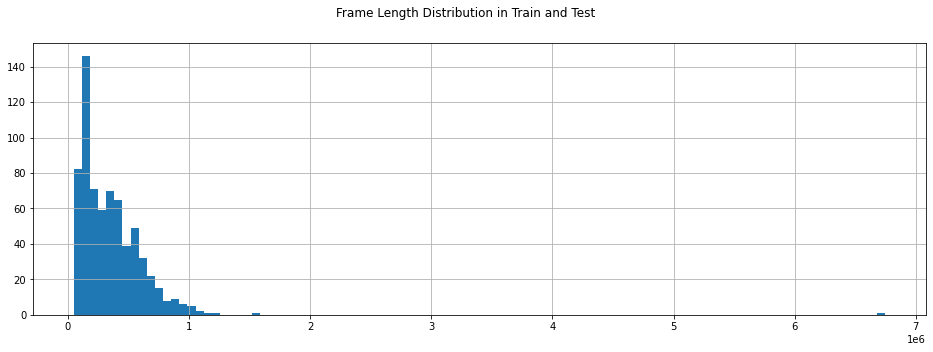

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
gt.nframes.hist(bins=100, ax=axes)
plt.suptitle('Frame Length Distribution in Train and Test', ha='center', fontsize='large');

In [148]:
IPython.display.display(ipd.Audio('./train/audio/000377.wav'))

In [100]:
# ann = pd.read_csv('annotations.csv')
# ann.head()

In [115]:
input_audio_filename = "./train/audio/000000.wav"
samplerate, data = wavfile.read(input_audio_filename)
print(samplerate, data.shape)

44100 (291576, 8)


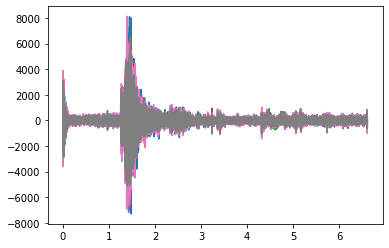

In [116]:
length = data.shape[0] / samplerate
time = np.linspace(0., length, data.shape[0])

for i in range(data.shape[1]):
  plt.plot(time, data[:, i], label="{} channel".format(i))

# 8 view sound
plt.show()

In [118]:
data, _ = librosa.core.load('./train/audio/000000.wav', 
                                    sr=160000,
                                    res_type='kaiser_fast')

In [119]:
IPython.display.Audio(data, rate=samplerate)

In [ ]:

audio_path = os.listdir('./train/audio')
audios = []

longest = 0
shortest = float('inf')
for files in audio_path:
  samplerate, data = wavfile.read(os.path.join('./train/audio', files))

  if data.shape[0] > longest:
    print(files)
    longest = data.shape[0]
    longest_audio = data
  
  if data.shape[0] < shortest:
    shortest = data.shape[0]
    shortest_audio = data

print(longest)
print(shortest)


In [ ]:
IPython.display.Audio(longest_audio[:, 0], rate=samplerate)

In [ ]:
IPython.display.Audio(shortest_audio[:, 0], rate=samplerate)

In [ ]:
data, _ = librosa.core.load('./train/audio/000001.wav', 
                                    sr=44100,
                                    res_type='kaiser_fast')
IPython.display.Audio(data, rate=44100)

In [ ]:
data_mfcc = librosa.feature.mfcc(data, sr=44100, n_mfcc=40)
plt.imshow(data_mfcc, cmap='hot', interpolation='nearest');

In [ ]:
class audioCorsmal(Dataset):
    def __init__(self, data_dir, label, config):
        self.data_dir = [os.path.join(data_dir, path) for path in sorted(os.listdir(data_dir))]
        self.label = label

        self.config = config

    def __len__(self):
        return len(self.data_dir)
    
    def __getitem__(self, idx):
        data, _ = librosa.core.load(self.data_dir[idx], 
                                    sr=self.config.sampling_rate,
                                    res_type='kaiser_fast')
        
        
            





In [130]:
from pyAudioAnalysis import audioBasicIO as aIO 


def midTermFeature_extraction(file_path):
  sampling_rate, signal = aIO.read_audio_file(file_path)
  signal = np.mean(signal,axis=1)
  mid_features, short_features, mid_feature_names = \
                  aF.mid_feature_extraction(signal, sampling_rate,
                                         round(1.0 * sampling_rate),
                                         round(1.0 * sampling_rate),
                                         round(sampling_rate * aT.shortTermWindow),
                                         round(sampling_rate * aT.shortTermStep))
                  
  mid_features = np.transpose(mid_features)
  mid_features = mid_features.mean(axis=0)

  return mid_features, mid_feature_names


mid_features, mid_feature_names = midTermFeature_extraction('./train/audio/000001.wav')


['zcr_mean', 'energy_mean', 'energy_entropy_mean', 'spectral_centroid_mean', 'spectral_spread_mean', 'spectral_entropy_mean', 'spectral_flux_mean', 'spectral_rolloff_mean', 'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean', 'chroma_2_mean', 'chroma_3_mean', 'chroma_4_mean', 'chroma_5_mean', 'chroma_6_mean', 'chroma_7_mean', 'chroma_8_mean', 'chroma_9_mean', 'chroma_10_mean', 'chroma_11_mean', 'chroma_12_mean', 'chroma_std_mean', 'delta zcr_mean', 'delta energy_mean', 'delta energy_entropy_mean', 'delta spectral_centroid_mean', 'delta spectral_spread_mean', 'delta spectral_entropy_mean', 'delta spectral_flux_mean', 'delta spectral_rolloff_mean', 'delta mfcc_1_mean', 'delta mfcc_2_mean', 'delta mfcc_3_mean', 'delta mfcc_4_mean', 'delta mfcc_5_mean', 'delta mfcc_6_mean', 'delta mfcc_7_mean', 'delta mfcc_8_mean', 'delta mfcc_9_

In [ ]:
from tqdm.notebook import tqdm
audio_folder = './train/audio'

audio_paths = [os.path.join(audio_folder, path) for path in sorted(os.listdir(audio_folder))]
audio_features = np.array([midTermFeature_extraction(audio_path) for audio_path in tqdm(audio_paths)])


In [132]:
audio_df = pd.DataFrame(data = audio_features, 
                        columns = mid_feature_names)

,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,mfcc_12_mean,mfcc_13_mean,chroma_1_mean,chroma_2_mean,chroma_3_mean,chroma_4_mean,chroma_5_mean,chroma_6_mean,chroma_7_mean,chroma_8_mean,chroma_9_mean,chroma_10_mean,chroma_11_mean,chroma_12_mean,chroma_std_mean,delta zcr_mean,delta energy_mean,delta energy_entropy_mean,delta spectral_centroid_mean,delta spectral_spread_mean,delta spectral_entropy_mean,...,chroma_8_std,chroma_9_std,chroma_10_std,chroma_11_std,chroma_12_std,chroma_std_std,delta zcr_std,delta energy_std,delta energy_entropy_std,delta spectral_centroid_std,delta spectral_spread_std,delta spectral_entropy_std,delta spectral_flux_std,delta spectral_rolloff_std,delta mfcc_1_std,delta mfcc_2_std,delta mfcc_3_std,delta mfcc_4_std,delta mfcc_5_std,delta mfcc_6_std,delta mfcc_7_std,delta mfcc_8_std,delta mfcc_9_std,delta mfcc_10_std,delta mfcc_11_std,delta mfcc_12_std,delta mfcc_13_std,delta chroma_1_std,delta chroma_2_std,delta chroma_3_std,delta chroma_4_std,delta chroma_5_std,delta chroma_6_std,delta chroma_7_std,delta chroma_8_std,delta chroma_9_std,delta chroma_10_std,delta chroma_11_std,delta chroma_12_std,delta chroma_std_std
0,0.053875,0.005389,2.996638,0.160577,0.217890,0.420793,0.007818,0.073377,-27.390427,2.664521,0.480871,-0.080103,-0.053409,0.553907,0.234600,-0.265333,-0.136773,0.191689,0.077047,0.108409,0.075447,0.007453,0.001072,0.130597,0.004950,0.021005,0.004619,0.120498,0.002642,0.003144,0.007276,0.035904,0.000990,0.053222,-0.000694,-0.000181,0.000165,-0.001035,-0.000071,-0.009145,...,0.002658,0.002355,0.007363,0.028449,0.000862,0.017415,0.020049,0.004288,0.187691,0.019822,0.010375,0.183645,0.004780,0.036793,0.741800,0.504648,0.310093,0.241660,0.229121,0.244152,0.198409,0.229052,0.194689,0.202643,0.208327,0.210631,0.184119,0.008396,0.001384,0.105047,0.005535,0.017461,0.005057,0.094918,0.003975,0.003561,0.010368,0.040992,0.001136,0.022717
1,0.014688,0.067757,2.959568,0.112870,0.218368,0.035672,0.013435,0.010358,-24.832584,3.634003,0.433670,0.170247,0.082084,0.506792,0.203723,-0.234826,-0.080718,0.211110,0.254650,0.232676,0.066906,0.006583,0.000507,0.095955,0.002912,0.014959,0.002992,0.148931,0.001587,0.004111,0.007326,0.094200,0.000753,0.057838,-0.000059,-0.000295,0.000962,-0.000073,0.000416,-0.000620,...,0.001870,0.003914,0.009889,0.052573,0.000781,0.013480,0.010926,0.041277,0.216753,0.021916,0.016089,0.040368,0.010789,0.006817,1.044774,0.530552,0.257986,0.231727,0.214849,0.219589,0.200971,0.289237,0.209765,0.188394,0.175058,0.174927,0.223361,0.008752,0.000877,0.072312,0.002886,0.016557,0.004415,0.108587,0.002768,0.005069,0.012348,0.059420,0.001195,0.019019
2,0.019224,0.005239,2.929171,0.125802,0.221696,0.072863,0.010887,0.013065,-27.945806,3.251382,0.295028,0.143069,0.058441,0.426387,0.180207,-0.314172,-0.111434,0.088975,0.098173,0.117805,0.064347,0.007985,0.000633,0.167185,0.005464,0.018248,0.003316,0.146751,0.001316,0.003340,0.005711,0.038919,0.000641,0.065854,-0.000161,-0.000006,-0.000410,-0.000301,0.000010,-0.001873,...,0.001368,0.003181,0.004820,0.026596,0.000740,0.017691,0.012489,0.004117,0.223639,0.020325,0.013625,0.076158,0.007095,0.012954,0.734381,0.442978,0.249999,0.253884,0.249249,0.203695,0.195568,0.240226,0.181069,0.200556,0.210344,0.195383,0.171835,0.009657,0.000940,0.125617,0.007559,0.018009,0.003765,0.101845,0.001978,0.004161,0.006777,0.039761,0.001046,0.025029
3,0.019266,0.014491,3.003146,0.120423,0.218716,0.055958,0.009524,0.013113,-26.271355,3.442410,0.497586,-0.014566,-0.068807,0.316638,0.085254,-0.201589,-0.003660,0.194293,-0.015094,0.047751,0.003202,0.010111,0.001356,0.145922,0.005514,0.018395,0.004546,0.142068,0.000715,0.004029,0.008603,0.045435,0.001397,0.058763,-0.001112,-0.000902,0.010557,-0.000099,-0.000276,-0.003623,...,0.000599,0.003487,0.00790

# Filling type (*XGBoost*)

In [142]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(audio_df, 
                                                    gt['filling type'], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [137]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [143]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgboost_model = xgb.XGBClassifier(learning_rate=0.03,
                                  n_estimators=200,
                                  max_depth=5,
                                  base_score=0.6,
                                  gamma=1,
                                  subsample=0.3,
                                  colsample_bytree=0.7,
                                  colsample_bylevel=0.4, 
                                  scale_pos_weight=5) #learning_rate=0.02,n_estimators=200,max_depth=5,base_score=0.5,scale_pos_weight=1
xgboost_model.fit(train_x, train_y)
prediction=xgboost_model.predict(test_x)
print("Acc: ",accuracy_score(test_y,prediction))


Acc:  0.9416058394160584


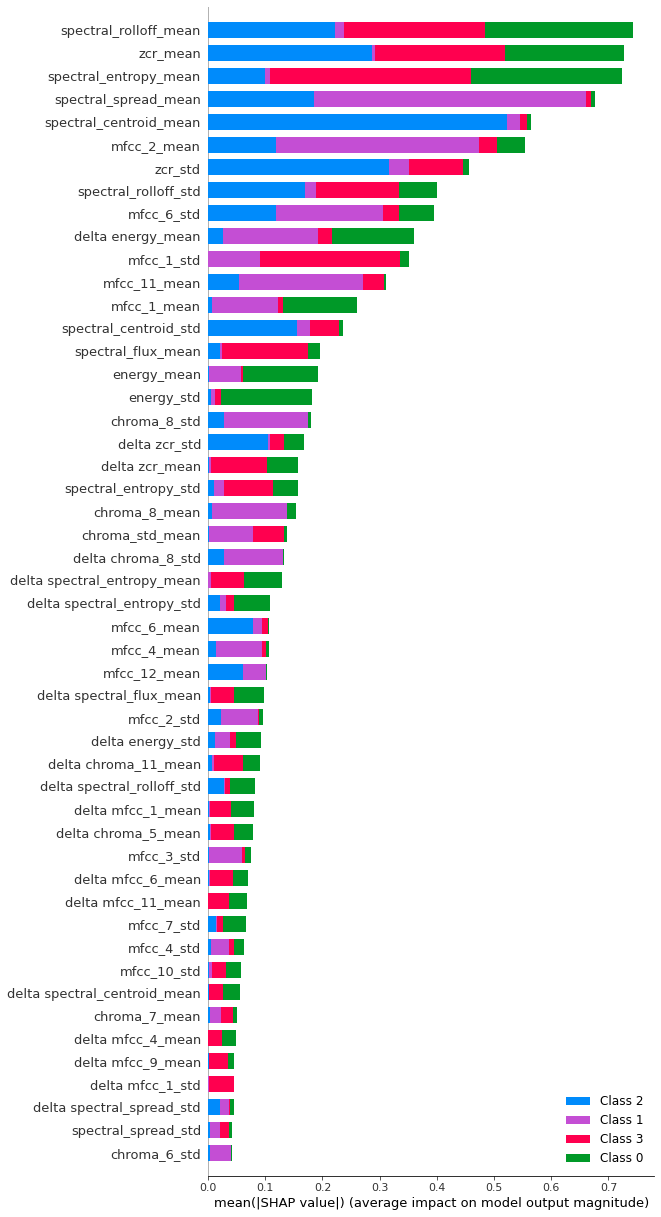

In [146]:
import shap
explainer = shap.TreeExplainer(xgboost_model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, train_x, plot_type="bar",max_display=50)

In [126]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel
thresholds = np.sort(xgboost_model.feature_importances_)


for thresh in thresholds[:]:
    selection = SelectFromModel(xgboost_model,threshold = thresh,prefit=True)
    select_X_train = selection.transform(train_x)
    selection_model = xgb.XGBClassifier(learning_rate=0.03,
                                        n_estimators=200,
                                        max_depth=5,
                                        base_score=0.6,
                                        gamma=1,
                                        subsample=0.3,
                                        colsample_bytree=0.7,
                                        colsample_bylevel=0.4, 
                                        scale_pos_weight=5)
    selection_model.fit(select_X_train, train_y.values.ravel())
    select_X_test = selection.transform(test_x)
    prediction = selection_model.predict(select_X_test)
    
    
    print("Thresh=%.3f, n=%d, Acc:%.2f%%" %
          (thresh, select_X_train.shape[1], accuracy_score(test_y,prediction) * 100))
    

Thresh=0.003, n=136, Acc:94.16%
Thresh=0.003, n=135, Acc:93.43%
Thresh=0.003, n=134, Acc:93.43%
Thresh=0.003, n=133, Acc:91.97%
Thresh=0.003, n=132, Acc:91.97%
Thresh=0.003, n=131, Acc:92.70%
Thresh=0.003, n=130, Acc:92.70%
Thresh=0.003, n=129, Acc:93.43%
Thresh=0.004, n=128, Acc:91.97%
Thresh=0.004, n=127, Acc:94.16%
Thresh=0.004, n=126, Acc:92.70%
Thresh=0.004, n=125, Acc:92.70%
Thresh=0.004, n=124, Acc:91.97%
Thresh=0.004, n=123, Acc:94.16%
Thresh=0.004, n=122, Acc:93.43%
Thresh=0.004, n=121, Acc:93.43%
Thresh=0.004, n=120, Acc:93.43%
Thresh=0.004, n=119, Acc:94.16%
Thresh=0.004, n=118, Acc:94.89%
Thresh=0.004, n=117, Acc:93.43%
Thresh=0.004, n=116, Acc:93.43%
Thresh=0.004, n=115, Acc:94.16%
Thresh=0.004, n=114, Acc:92.70%
Thresh=0.004, n=113, Acc:92.70%
Thresh=0.004, n=112, Acc:94.16%
Thresh=0.004, n=111, Acc:94.16%
Thresh=0.004, n=110, Acc:92.70%
Thresh=0.004, n=109, Acc:92.70%
Thresh=0.005, n=108, Acc:93.43%
Thresh=0.005, n=107, Acc:92.70%
Thresh=0.005, n=106, Acc:94.16%
Thresh=0

# Filling level (*XGBoost*)

In [149]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(audio_df, 
                                                    gt['filling level'], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [153]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [150]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgboost_model = xgb.XGBClassifier(learning_rate=0.03,
                                  n_estimators=200,
                                  max_depth=5,
                                  base_score=0.6,
                                  gamma=1,
                                  subsample=0.3,
                                  colsample_bytree=0.7,
                                  colsample_bylevel=0.4, 
                                  scale_pos_weight=5) #learning_rate=0.02,n_estimators=200,max_depth=5,base_score=0.5,scale_pos_weight=1
xgboost_model.fit(train_x, train_y)
prediction=xgboost_model.predict(test_x)
print("Acc: ",accuracy_score(test_y,prediction))


Acc:  0.6642335766423357


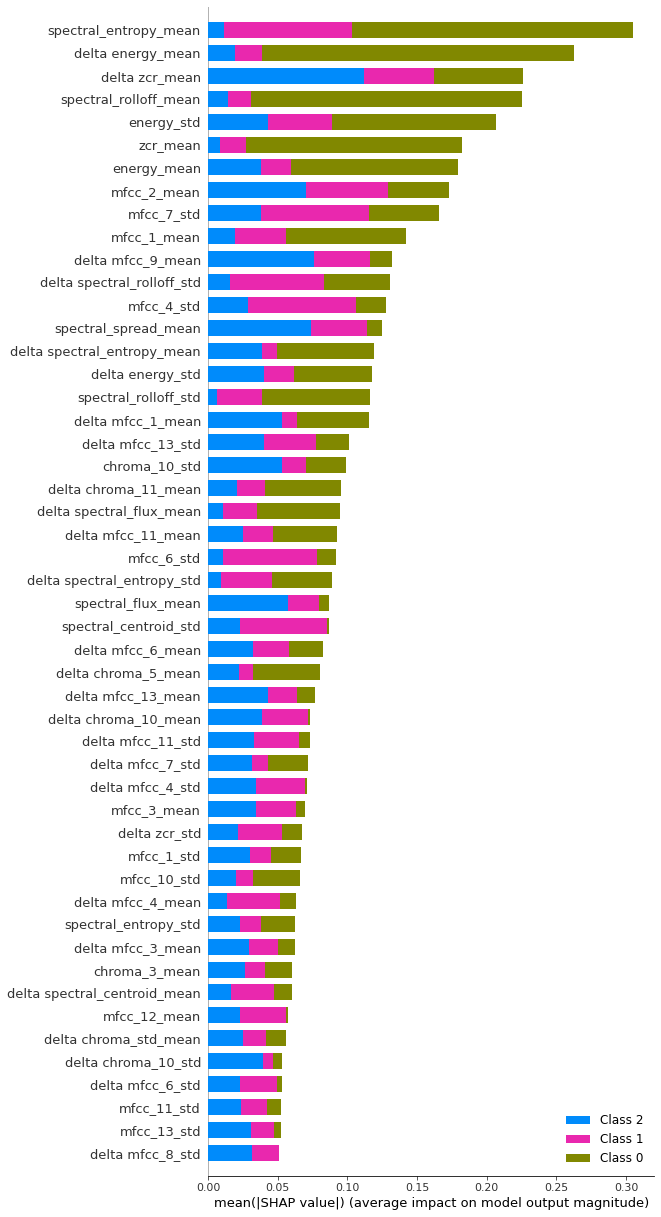

In [151]:
import shap
explainer = shap.TreeExplainer(xgboost_model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, train_x, plot_type="bar",max_display=50)

In [154]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel
thresholds = np.sort(xgboost_model.feature_importances_)


for thresh in thresholds[:]:
    selection = SelectFromModel(xgboost_model,threshold = thresh,prefit=True)
    select_X_train = selection.transform(train_x)
    selection_model = xgb.XGBClassifier(learning_rate=0.03,
                                        n_estimators=200,
                                        max_depth=5,
                                        base_score=0.6,
                                        gamma=1,
                                        subsample=0.3,
                                        colsample_bytree=0.7,
                                        colsample_bylevel=0.4, 
                                        scale_pos_weight=5)
    selection_model.fit(select_X_train, train_y.values.ravel())
    select_X_test = selection.transform(test_x)
    prediction = selection_model.predict(select_X_test)
    
    
    print("Thresh=%.3f, n=%d, Acc:%.2f%%" %
          (thresh, select_X_train.shape[1], accuracy_score(test_y,prediction) * 100))
    

Thresh=0.005, n=136, Acc:66.42%
Thresh=0.005, n=135, Acc:64.23%
Thresh=0.005, n=134, Acc:65.69%
Thresh=0.006, n=133, Acc:63.50%
Thresh=0.006, n=132, Acc:66.42%
Thresh=0.006, n=131, Acc:64.23%
Thresh=0.006, n=130, Acc:66.42%
Thresh=0.006, n=129, Acc:65.69%
Thresh=0.006, n=128, Acc:65.69%
Thresh=0.006, n=127, Acc:67.88%
Thresh=0.006, n=126, Acc:64.96%
Thresh=0.006, n=125, Acc:64.96%
Thresh=0.006, n=124, Acc:64.96%
Thresh=0.006, n=123, Acc:65.69%
Thresh=0.006, n=122, Acc:66.42%
Thresh=0.006, n=121, Acc:70.07%
Thresh=0.006, n=120, Acc:63.50%
Thresh=0.006, n=119, Acc:64.96%
Thresh=0.006, n=118, Acc:67.15%
Thresh=0.006, n=117, Acc:65.69%
Thresh=0.006, n=116, Acc:69.34%
Thresh=0.006, n=115, Acc:67.15%
Thresh=0.006, n=114, Acc:67.15%
Thresh=0.006, n=113, Acc:66.42%
Thresh=0.006, n=112, Acc:63.50%
Thresh=0.006, n=111, Acc:67.15%
Thresh=0.006, n=110, Acc:65.69%
Thresh=0.006, n=109, Acc:64.23%
Thresh=0.006, n=108, Acc:67.15%
Thresh=0.006, n=107, Acc:64.96%
Thresh=0.006, n=106, Acc:67.15%
Thresh=0

In [68]:
import numpy as np


array([1.93145607])